In [1]:
import os
import joblib
import zipfile
import warnings
warnings.simplefilter(action = "ignore")
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
import numpy as np
import pandas as pd
import scipy
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, roc_auc_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
fraud_detection_df = pd.read_csv('Fraud_Detection_Dataset.csv')

In [4]:
fraud_detection_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
fraud_detection_df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [5]:
fraud_detection_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Data Cleaning

In [6]:
fraud_detection_df['step'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [7]:
fraud_detection_df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
print(f"Data shape: {fraud_detection_df.shape}")

Data shape: (6362620, 11)


In [9]:
fraud_detection_df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [10]:
type = fraud_detection_df['type'].value_counts()

In [11]:
fraud_detection_df = fraud_detection_df.dropna()
fraud_detection_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


Clean dataset

In [ ]:
def filter_merchants_users(data):
  data = fraud_detection_df[fraud_detection_df['nameDest'].str.contains("M") == False]
  data.reset_index(drop = True, inplace = True)
  return  data

def unnecessary_var(data):
  drop_list = ['nameOrig','isFlaggedFraud', 'nameDest']
  data.drop(columns = drop_list, inplace = True)
  return data

In [ ]:
fraud_detection_df_copy = fraud_detection_df.copy(deep = True)

In [ ]:
df_m = (
    fraud_detection_df_copy
    .pipe(filter_merchants_users)
    .pipe(unnecessary_var)
)
print(df_m.shape)
df_m.head(4)

(4211125, 8)


C:\Users\PC\AppData\Local\Temp\ipykernel_22912\4203825272.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns = drop_list, inplace = True)


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.00,181.0,0.00,0.0,0.00,1
1,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.00,1
2,1,DEBIT,5337.77,41720.0,36382.23,41898.0,40348.79,0
3,1,DEBIT,9644.94,4465.0,0.00,10845.0,157982.12,0


## EDA (Eploratory data analysis)

Unique value - numerical variables

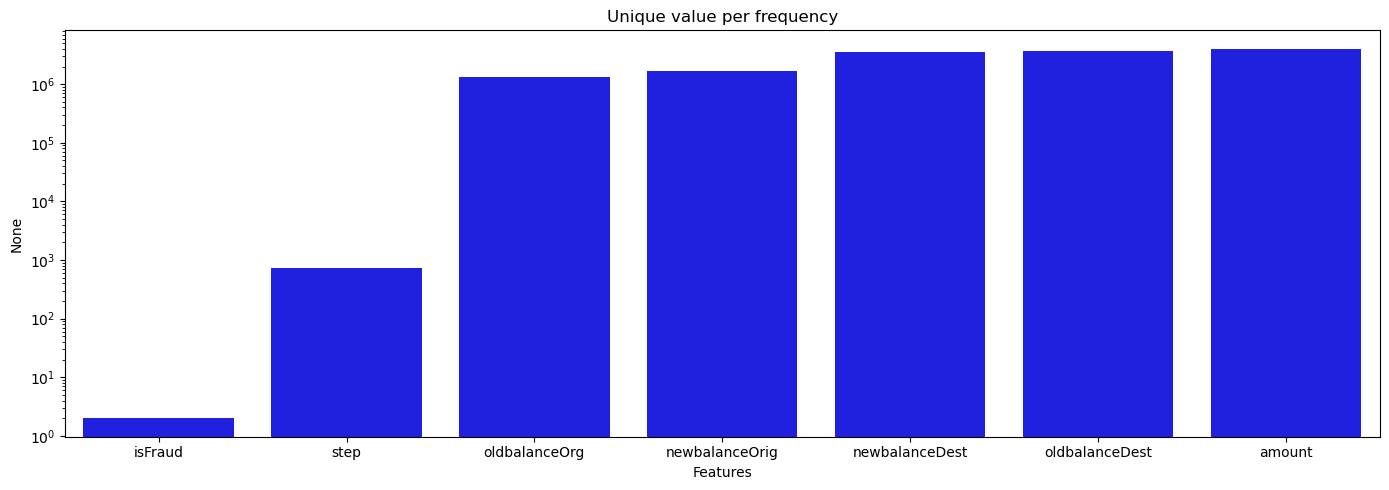

In [15]:
unique_value = df_m.select_dtypes("number").nunique().sort_values()

fig, ax = plt.subplots(figsize = (14, 5))
sns.barplot(x = unique_value.index, y = unique_value, color = 'Blue', ax = ax)
ax.set_yscale("log")
ax.set_xlabel("Features")
ax.set_title("Unique value per frequency")
plt.tight_layout()

<Axes: >

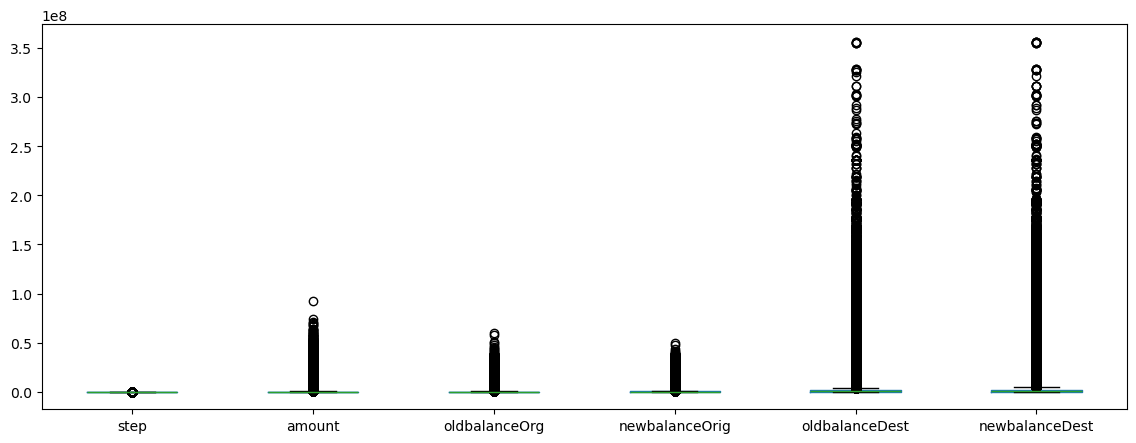

In [16]:
df_m.drop(columns = "isFraud").boxplot(grid = False, figsize = (14, 5))

In [18]:
df_m.describe().T

,count,mean,std,min,25%,50%,75%,max
step,4211125.0,2.428961e+02,1.421435e+02,1.0,155.00,237.00,334.00,7.430000e+02
amount,4211125.0,2.650835e+05,7.275891e+05,0.0,76085.56,158943.21,278485.01,9.244552e+07
oldbalanceOrg,4211125.0,1.225068e+06,3.482978e+06,0.0,0.00,18155.00,191127.82,5.958504e+07
newbalanceOrig,4211125.0,1.260404e+06,3.523174e+06,0.0,0.00,0.00,284954.41,4.958504e+07
oldbalanceDest,4211125.0,1.663058e+06,4.064780e+06,0.0,139659.05,551247.21,1692950.88,3.560159e+08
newbalanceDest,4211125.0,1.850856e+06,4.386080e+06,0.0,221717.59,683724.79,1910978.53,3.561793e+08
isFraud,4211125.0,1.950310e-03,4.411924e-02,0.0,0.00,0.00,0.00,1.000000e+00


In [146]:
df_m.describe(include = "object")

,type
count,4211125
unique,4
top,CASH_OUT
freq,2237500


In [25]:
df_m['isFraud'].value_counts()

isFraud
0    4202912
1       8213
Name: count, dtype: int64

Label Distribution

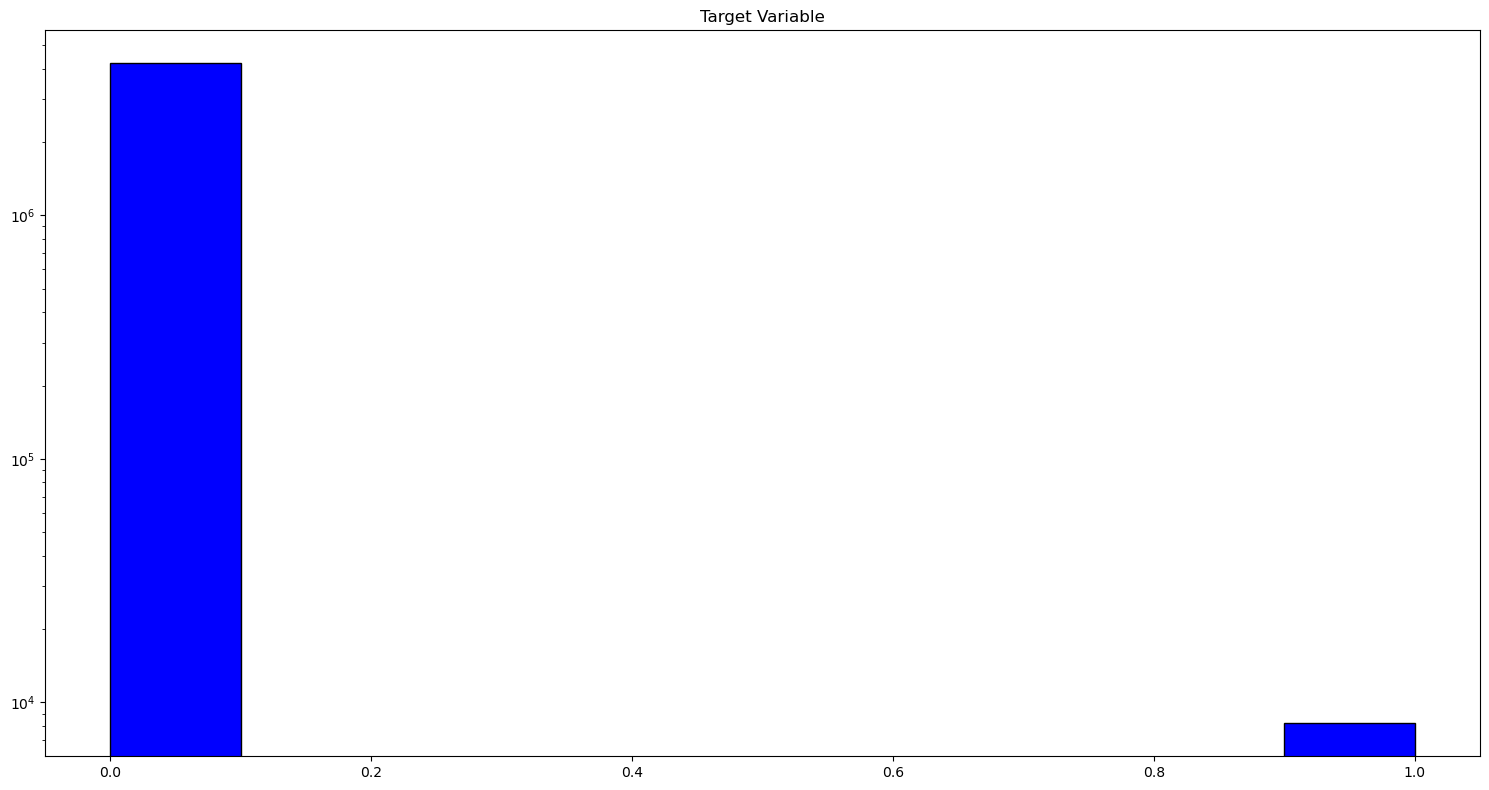

In [22]:
df_m['isFraud'].hist(figsize = (15, 8), color = "blue", grid = False, edgecolor = "black")
plt.yscale("log")
plt.title("Target Variable")
plt.tight_layout()

Feature distribution

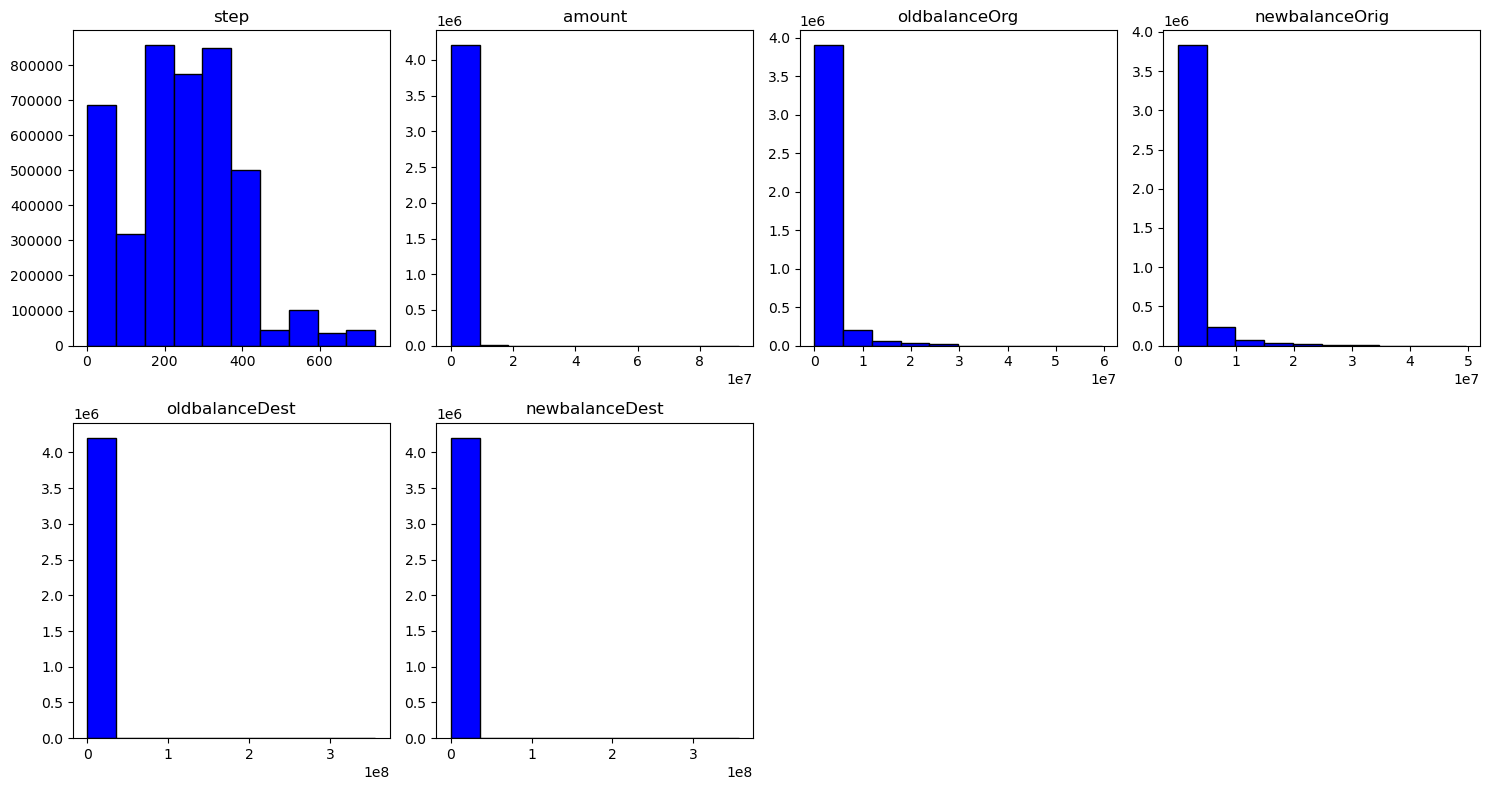

In [ ]:
df_m.drop(columns = 'isFraud').hist(bins = 10, figsize = (15, 8), layout = (-1, 4), grid = False, color = "blue", edgecolor = "black")
plt.tight_layout()

Kurtosis and skew

In [81]:
num_features = [colm for colm in df_m.select_dtypes("number").columns if colm != "isFraud"]

for c in num_features:
    kurt = scipy.stats.mstats.kurtosis(df_m[c])
    Skew = scipy.stats.mstats.skew(df_m[c])
    
    print(f"{c} Skew: {np.round(Skew, 2)}, Kurtosis: {np.round(kurt, 2)}")

step Skew: 0.38, Kurtosis: 0.34
amount Skew: 26.42, Kurtosis: 1275.57
oldbalanceOrg Skew: 4.18, Kurtosis: 20.69
newbalanceOrig Skew: 4.13, Kurtosis: 20.11
oldbalanceDest Skew: 17.2, Kurtosis: 690.56
newbalanceDest Skew: 16.77, Kurtosis: 630.94


Feature patters

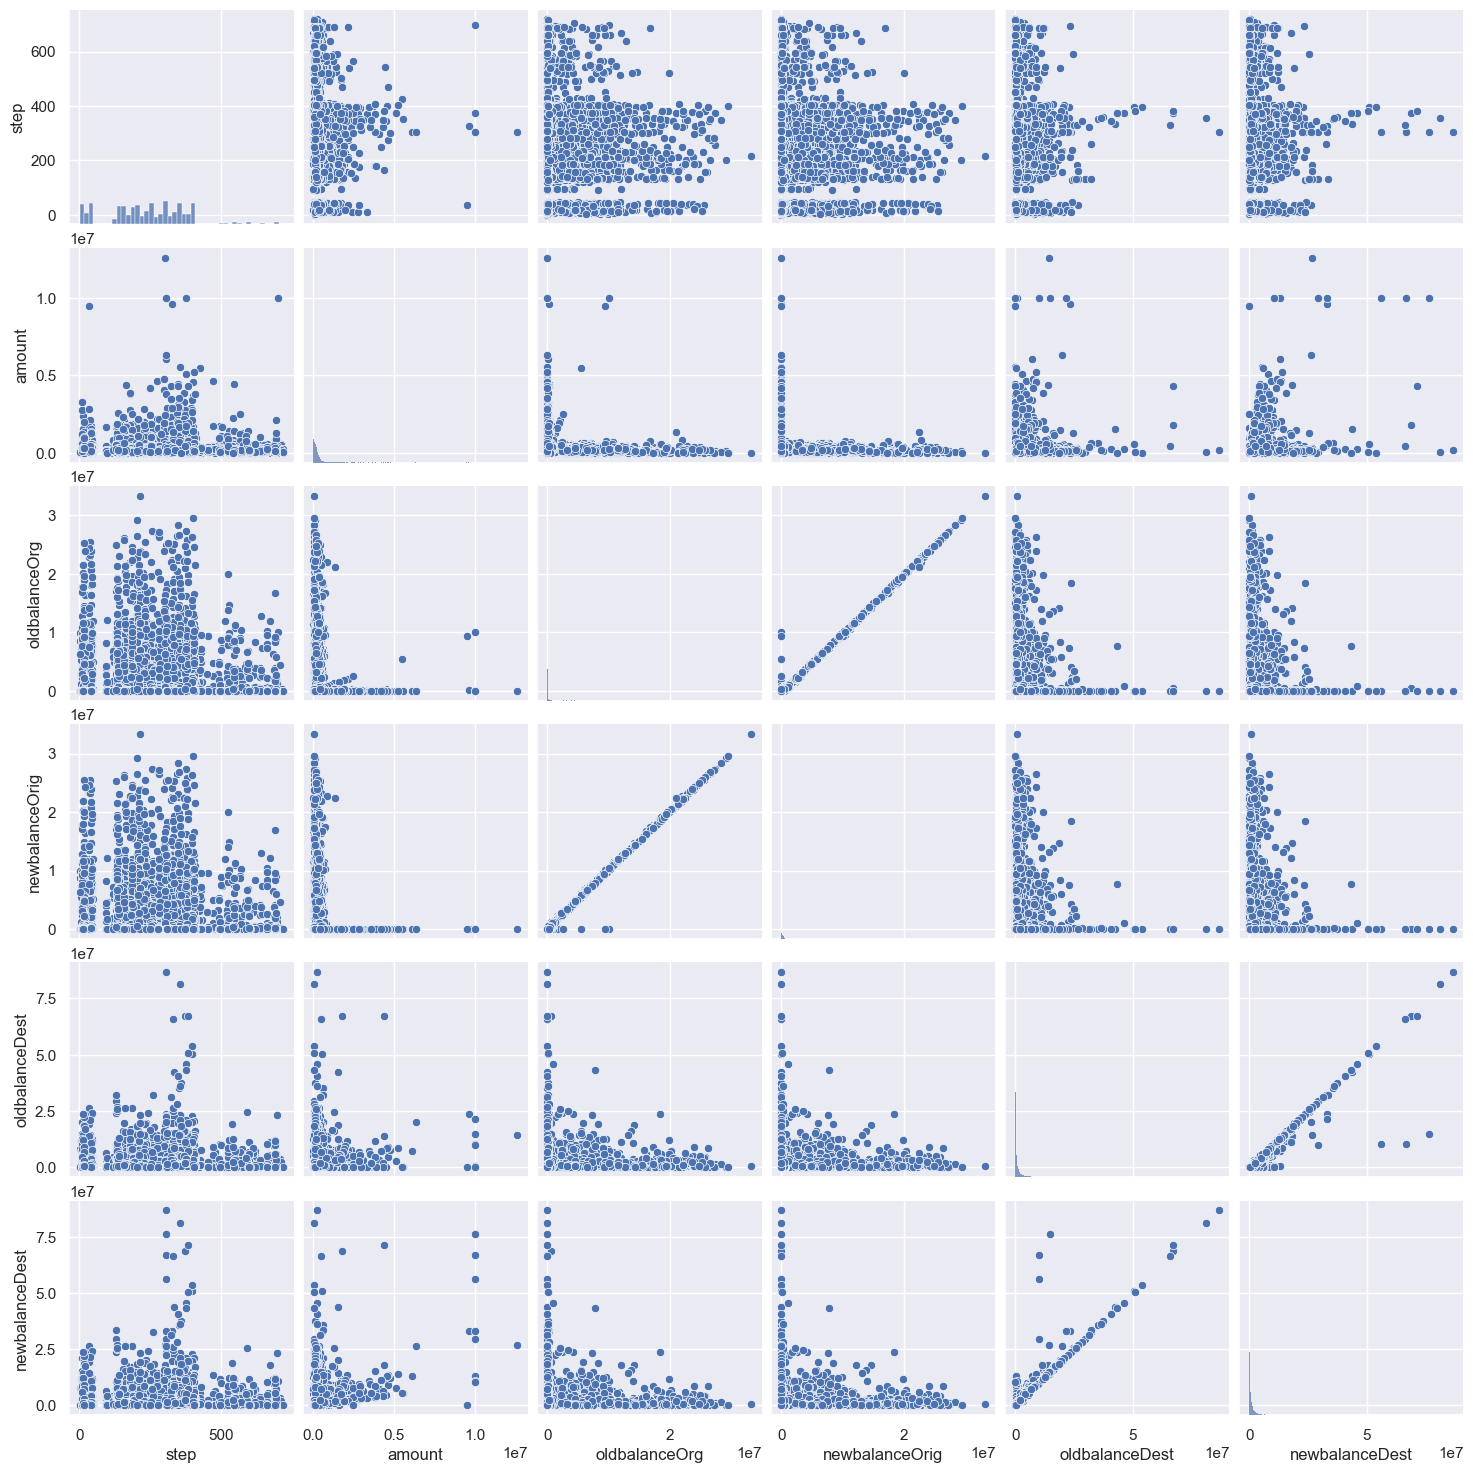

In [ ]:
feat_continues = df_m.select_dtypes("number").drop(columns = ["isFraud"])
sample_size = 10000  # Kích thước mẫu
feat_continues_sample = feat_continues.sample(n=sample_size, random_state=42)

# Vẽ biểu đồ pairplot với mẫu
sns.set(rc={'figure.figsize':(14,8)})
sns.pairplot(feat_continues_sample)
sns.set_context('talk')
sns.set_style('white')

Correlaction (pearson and spermean)

In [83]:
pearson_corr = df_m.select_dtypes(include=[np.number]).corr(method='pearson')
spearman_corr = df_m.select_dtypes(include=[np.number]).corr(method='spearman')

<Axes: >

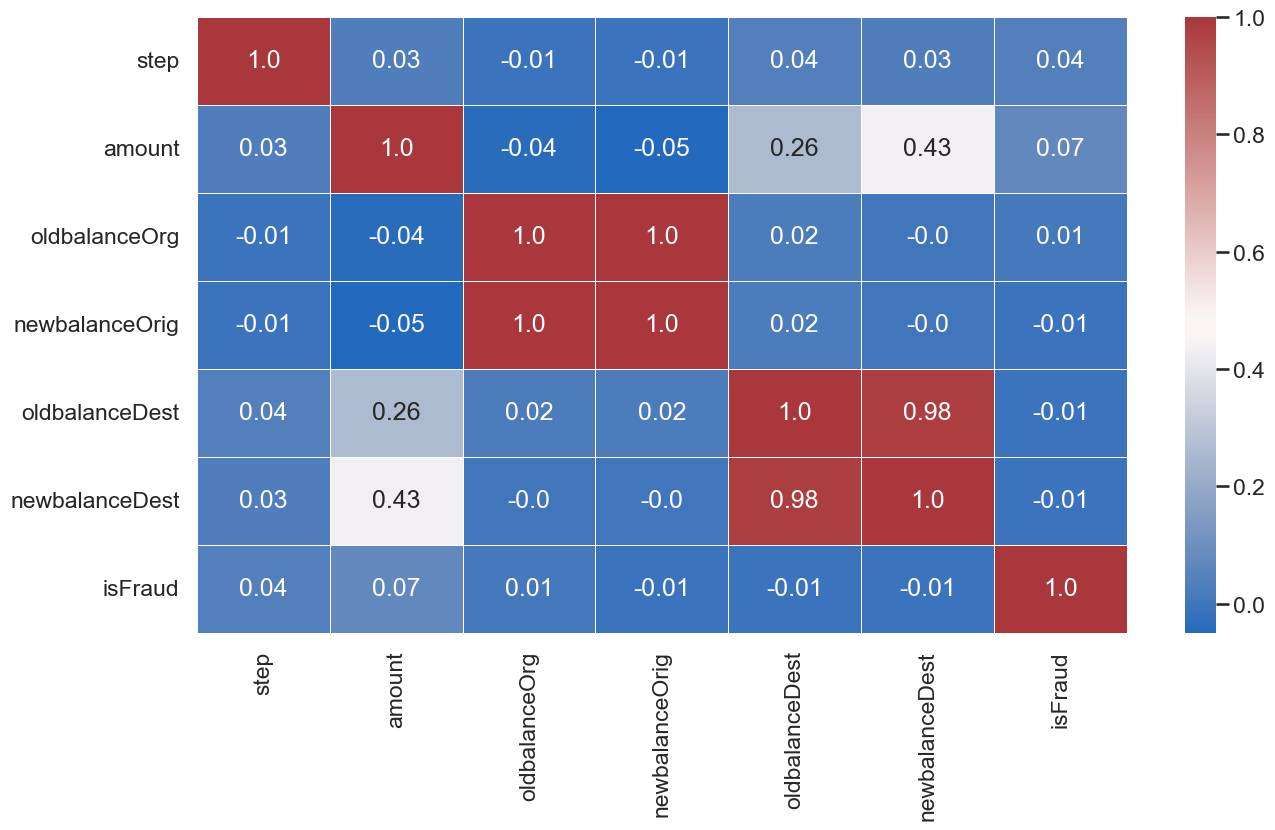

In [85]:
# pearson
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(np.round(pearson_corr, 2), annot = True, fmt = "", linewidths = .5,cmap ="vlag", ax = ax)

<Axes: >

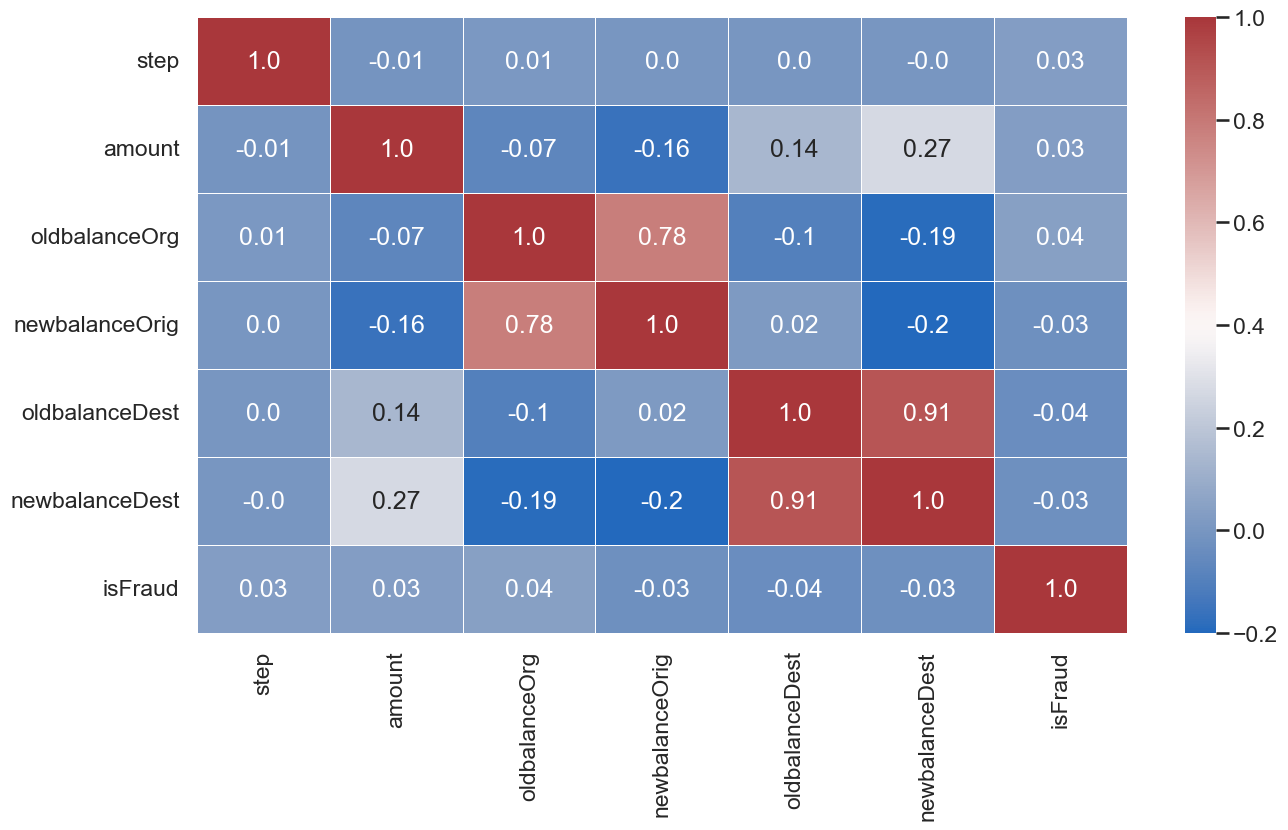

In [86]:
#spearman
fig, ax = plt.subplots(figsize=(15,8))

sns.heatmap(np.round(spearman_corr, 2), square = False, annot = True, fmt = "", linewidths = .5,cmap ="vlag", ax = ax)

Boxplot per step (time of transaction)

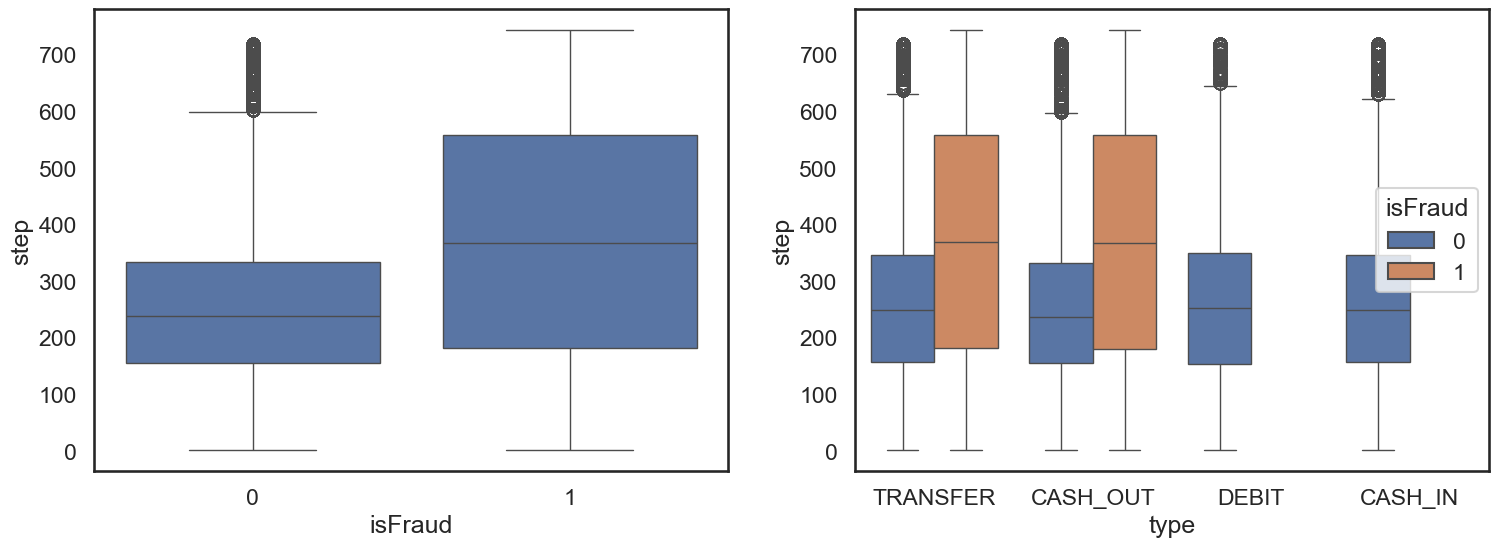

In [87]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
ax.ravel()

## Fraud per amount of transactions
sns.boxplot(
    data = df_m,
    x = 'isFraud',
    y = 'step',
    ax = ax[0]
)
## type of pay
sns.boxplot(
    data = df_m,
    x = 'type',
    y = 'step',
    hue = 'isFraud',
    ax = ax[1]
)

## Data Preprocessing

Tối ưu hóa chỉ số Kurtosis and skew của dữ liệu

In [ ]:
df_processed = df_m.copy()

skewed_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

for col in skewed_columns:
    df_processed[col] = np.log1p(df_processed[col])

for col in skewed_columns:
    lower_limit = df_processed[col].quantile(0.01) 
    upper_limit = df_processed[col].quantile(0.99)  
    df_processed[col] = np.clip(df_processed[col], lower_limit, upper_limit)

import scipy.stats
for col in skewed_columns:
    skew = scipy.stats.mstats.skew(df_processed[col])
    kurt = scipy.stats.mstats.kurtosis(df_processed[col])
    print(f"{col}: Skew: {np.round(skew, 2)}, Kurtosis: {np.round(kurt, 2)}")

amount: Skew: -0.87, Kurtosis: 1.58
oldbalanceOrg: Skew: -0.28, Kurtosis: -1.4
newbalanceOrig: Skew: 0.5, Kurtosis: -1.62
oldbalanceDest: Skew: -1.8, Kurtosis: 1.82
newbalanceDest: Skew: -2.59, Kurtosis: 6.25


In [77]:
df_processed['isFraud'].value_counts()

isFraud
0    4202912
1       8213
Name: count, dtype: int64

Giảm kích thước dữ liệu

In [ ]:
from sklearn.utils import resample
import pandas as pd

df_majority = df_processed[df_processed['isFraud'] == 0]
df_minority = df_processed[df_processed['isFraud'] == 1]

df_majority_downsampled = resample(df_majority, 
                                   replace=False,  
                                   n_samples=len(df_minority)*2, 
                                   random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority])
print(df_balanced['isFraud'].value_counts())

isFraud
0    16426
1     8213
Name: count, dtype: int64


Feature distribution Df_Balanced

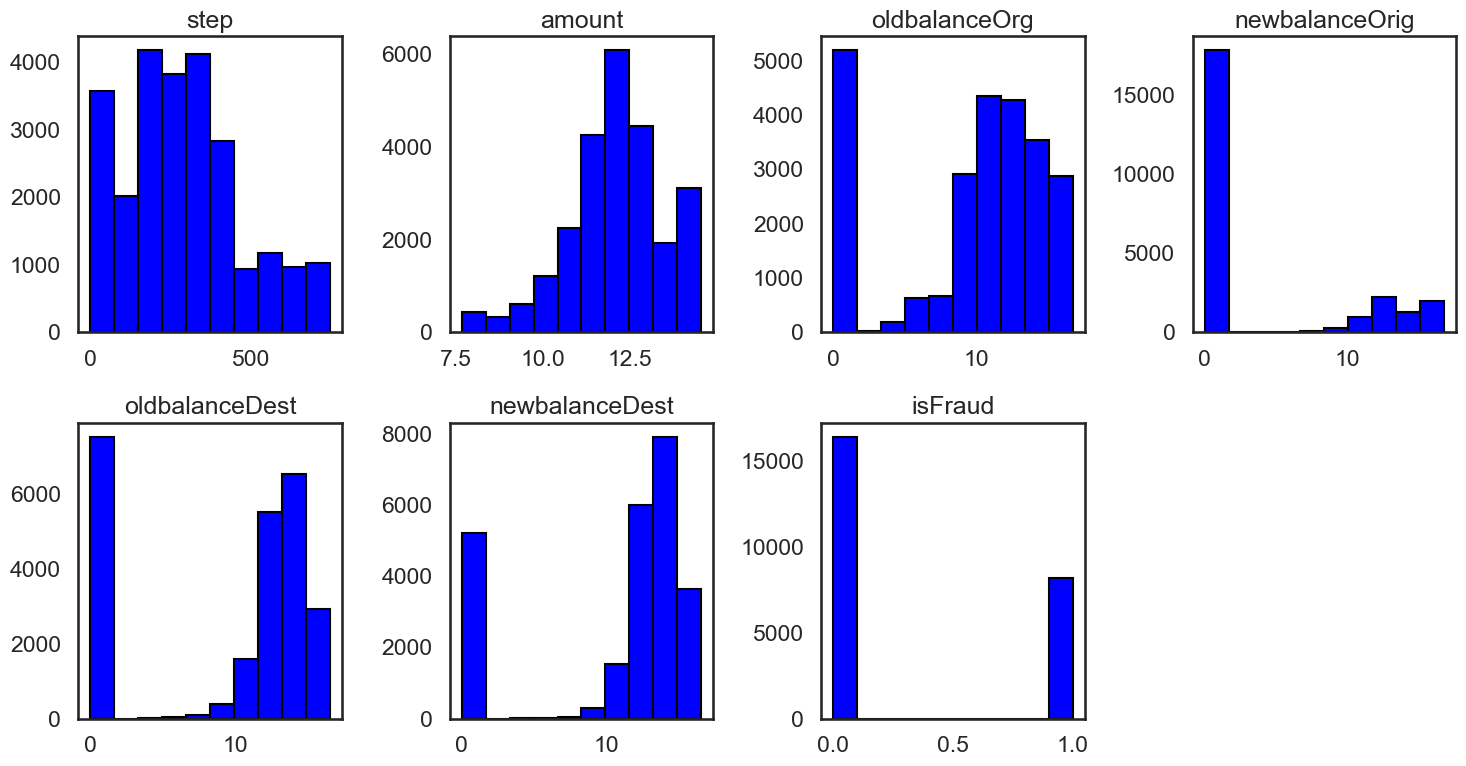

In [91]:
# Feature distributions
df_balanced.hist(bins = 10, figsize = (15, 8), layout = (-1, 4), grid = False, color = "blue", edgecolor = "black")
plt.tight_layout()

Kurtosis and skew của Df_Balanced

In [92]:
num_features = [colm for colm in df_balanced.select_dtypes("number").columns if colm != "isFraud"]

for c in num_features:
    kurt = scipy.stats.mstats.kurtosis(df_balanced[c])
    Skew = scipy.stats.mstats.skew(df_balanced[c])
    
    print(f"{c} Skew: {np.round(Skew, 2)}, Kurtosis: {np.round(kurt, 2)}")

step Skew: 0.54, Kurtosis: -0.24
amount Skew: -0.47, Kurtosis: 0.58
oldbalanceOrg Skew: -0.82, Kurtosis: -0.71
newbalanceOrig Skew: 1.1, Kurtosis: -0.65
oldbalanceDest Skew: -0.7, Kurtosis: -1.34
newbalanceDest Skew: -1.22, Kurtosis: -0.25


In [93]:
df_balanced

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
1030116,154,CASH_OUT,11.038632,0.000000,0.000000,12.706086,12.878966,0
957634,140,CASH_OUT,12.253486,10.043771,0.000000,13.830692,14.018457,0
4029312,522,CASH_OUT,10.466001,11.413492,10.922956,13.993441,14.022397,0
200404,16,CASH_IN,9.862647,15.220095,15.224796,13.205290,13.169309,0
2758159,304,CASH_OUT,10.584351,0.000000,0.000000,16.068181,16.072325,0
...,...,...,...,...,...,...,...,...
4211120,743,CASH_OUT,12.735768,12.735768,0.000000,0.000000,12.735768,1
4211121,743,TRANSFER,14.542343,15.657870,0.000000,0.000000,0.000000,1
4211122,743,CASH_OUT,14.542343,15.657870,0.000000,11.134441,15.668663,1
4211123,743,TRANSFER,13.652996,13.652996,0.000000,0.000000,0.000000,1


In [94]:
type_dict = {
    'PAYMENT':0,
    'TRANSFER':1,
    'CASH_OUT':2,
    'DEBIT':3,
    'CASH_IN':4
}
df_balanced['type'] = df_balanced['type'].map(type_dict)

In [95]:
df_balanced

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
1030116,154,2,11.038632,0.000000,0.000000,12.706086,12.878966,0
957634,140,2,12.253486,10.043771,0.000000,13.830692,14.018457,0
4029312,522,2,10.466001,11.413492,10.922956,13.993441,14.022397,0
200404,16,4,9.862647,15.220095,15.224796,13.205290,13.169309,0
2758159,304,2,10.584351,0.000000,0.000000,16.068181,16.072325,0
...,...,...,...,...,...,...,...,...
4211120,743,2,12.735768,12.735768,0.000000,0.000000,12.735768,1
4211121,743,1,14.542343,15.657870,0.000000,0.000000,0.000000,1
4211122,743,2,14.542343,15.657870,0.000000,11.134441,15.668663,1
4211123,743,1,13.652996,13.652996,0.000000,0.000000,0.000000,1


In [96]:
df_balanced['type'].value_counts()

type
2    12849
1     6174
4     5476
3      140
Name: count, dtype: int64

In [97]:
X = df_balanced[['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
y = df_balanced['isFraud']

In [98]:
X

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
1030116,154,2,11.038632,0.000000,0.000000,12.706086,12.878966
957634,140,2,12.253486,10.043771,0.000000,13.830692,14.018457
4029312,522,2,10.466001,11.413492,10.922956,13.993441,14.022397
200404,16,4,9.862647,15.220095,15.224796,13.205290,13.169309
2758159,304,2,10.584351,0.000000,0.000000,16.068181,16.072325
...,...,...,...,...,...,...,...
4211120,743,2,12.735768,12.735768,0.000000,0.000000,12.735768
4211121,743,1,14.542343,15.657870,0.000000,0.000000,0.000000
4211122,743,2,14.542343,15.657870,0.000000,11.134441,15.668663
4211123,743,1,13.652996,13.652996,0.000000,0.000000,0.000000


In [99]:
y

1030116    0
957634     0
4029312    0
200404     0
2758159    0
          ..
4211120    1
4211121    1
4211122    1
4211123    1
4211124    1
Name: isFraud, Length: 24639, dtype: int64

In [100]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, roc_auc_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [101]:
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (24639, 7)
Labels shape: (24639,)


Chia dữ liệu thành 3 tập: Huấn luyện, Xác thực, Kiểm tra

In [102]:
split_train = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
split_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

In [103]:
def train_test_val_split(X, y, split_train, split_val):
    train_idx_first, test_idx = next(split_train.split(X, y))

    X_train_first = X.iloc[train_idx_first]
    y_train_first = y.iloc[train_idx_first]

    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]

    train_idx, val_idx = next(split_val.split(X_train_first, y_train_first))

    X_train = X_train_first.iloc[train_idx]
    y_train = y_train_first.iloc[train_idx]

    X_val = X.iloc[val_idx]
    y_val = y.iloc[val_idx]

    return X_train, y_train, X_test, y_test, X_val, y_val

In [104]:
X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(X, y, split_train, split_val)

In [105]:
X_train

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
1275815,166,2,12.557143,11.934054,0.000000,0.000000,12.557143
3638681,379,2,11.848749,9.265302,0.000000,14.006252,14.115655
3428680,358,4,10.644980,14.627494,14.645961,11.973482,11.665778
2355025,260,1,12.075956,12.075956,0.000000,0.000000,0.000000
2111212,238,2,7.684872,7.334225,0.000000,13.863451,13.864909
...,...,...,...,...,...,...,...
691115,94,2,12.813989,0.000000,0.000000,14.659640,14.806267
3025336,327,2,10.879197,10.457689,0.000000,0.000000,10.879197
811339,133,2,9.697417,9.697417,0.000000,10.697525,11.010741
1138356,160,2,12.584259,0.000000,0.000000,13.363358,13.740984


In [106]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape:{X_val.shape}")
print(f"X_test shape:{X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (14783, 7)
X_val shape:(4928, 7)
X_test shape:(4928, 7)
y_train shape: (14783,)
y_val shape: (4928,)
y_test shape: (4928,)


Đánh giá hiệu suất 3 mô hình

In [128]:
def model_performance_val(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred)
    return accuracy, recall, precision, f1, roc_auc

In [129]:
rdf_model = RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1)
lg_model = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=200, class_weight='balanced',random_state=42)
xgb_model = xgb.XGBClassifier(seed=42)

In [130]:
model_per_val_rdf = model_performance_val(rdf_model, X_train, y_train, X_val, y_val)
model_per_val_lg = model_performance_val(lg_model, X_train, y_train, X_val, y_val)
model_per_val_xgb = model_performance_val(xgb_model, X_train, y_train, X_val, y_val)

In [131]:
accuracy_scores = []
recall_scores = []
precision_scores = []
f1_scores = []
roc_auc_scores = []
def scores_arr(score):
    accuracy, recall, precision, f1, roc_auc = score
    accuracy_scores.append(accuracy)
    recall_scores.append(recall)
    precision_scores.append(precision)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

In [132]:
scores_arr(model_per_val_rdf)
scores_arr(model_per_val_lg)
scores_arr(model_per_val_xgb)

In [133]:
models = {
    'Random Forest Classifier':rdf_model,
    'Logistic Regression':lg_model,
    'XGB Classifier': xgb_model
}

In [134]:
performance_df = pd.DataFrame({'Model': models.keys(), 'Accuracy':accuracy_scores, 'Recall':recall_scores, 'Precision':precision_scores, 'F1':f1_scores, 'Roc_auc':roc_auc_scores})
performance_df

,Model,Accuracy,Recall,Precision,F1,Roc_auc
0,Random Forest Classifier,0.996753,0.990783,0.990783,0.990783,0.994406
1,Logistic Regression,0.944196,0.965438,0.773777,0.859047,0.952546
2,XGB Classifier,0.995942,0.990783,0.986239,0.988506,0.993914


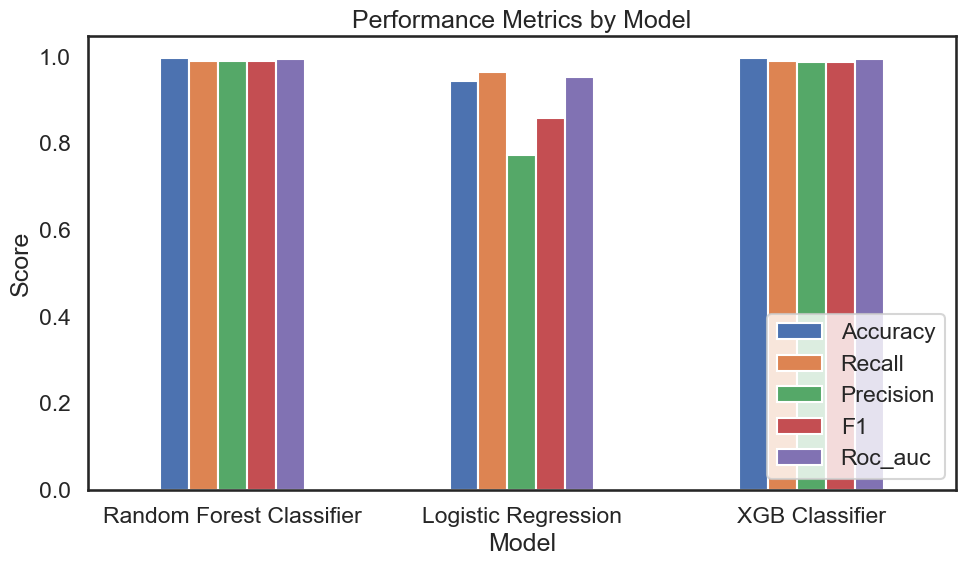

In [139]:
fig, ax = plt.subplots(figsize = (10, 6))
performance_df.plot(x='Model', y=['Accuracy', 'Recall', 'Precision', 'F1', 'Roc_auc'], kind='bar', ax=ax)
plt.title('Performance Metrics by Model')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation = 0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Tối ưu hóa tham số của Random Forest

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
strkf = StratifiedKFold(n_splits=4)
space = {
    'n_estimators': scope.int(hp.uniform('n_estimators', 50, 300)),  
    'max_depth': scope.int(hp.uniform('max_depth', 3, 20)),           
    'min_samples_split': hp.randint('min_samples_split', 2, 10),  
    'min_samples_leaf': hp.randint('min_samples_leaf', 1, 10),       
    'max_features': hp.uniform('max_features', 0.5, 1.0),             
    'bootstrap': hp.choice('bootstrap', [True, False]),                
    'random_state': 42,                                            
}
def objective(param):
    model = RandomForestClassifier(**param)
    roc_auc = cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=strkf).mean()
    return {'loss': -roc_auc, 'status': STATUS_OK}
trials = Trials()
best = fmin(fn=objective,          # Hàm mục tiêu
            space=space,           # Không gian tìm kiếm
            algo=tpe.suggest,      # Thuật toán tối ưu hóa (TPE)
            max_evals=70,          # Số lượng thử nghiệm tối đa
            trials=trials)         # Lưu lại thông tin về các thử nghiệm
print("Best hyperparameters:", best)


100%|██████████| 70/70 [15:19<00:00, 13.13s/trial, best loss: -0.9986828085637244]
Best hyperparameters: {'bootstrap': 0, 'max_depth': 12.98449798635732, 'max_features': 0.7589920792536271, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 182.4608942979555}


Mô hình cuối cùng

In [142]:
final_rdf_model = RandomForestClassifier(
    bootstrap=False,
    max_depth=int(best['max_depth']),
    max_features=best['max_features'],
    min_samples_leaf=best['min_samples_leaf'],
    min_samples_split=best['min_samples_split'],
    n_estimators=int(best['n_estimators'])
)
final_rdf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=12,
                       max_features=0.7589920792536271, min_samples_leaf=2,
                       min_samples_split=9, n_estimators=182)

In [147]:
def model_performance_test(y_test, y_pred):
    scores = pd.DataFrame({
        'accuracy_score': accuracy_score(y_test, y_pred),
        'precision_score': precision_score(y_test, y_pred),
        'recall_score': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc_score': roc_auc_score(y_test, y_pred)
    }, index= [0])
    return scores

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_performance(scores):
    scores_melted = scores.melt(var_name="Metric", value_name="Score")
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x="Metric", y="Score", data=scores_melted, palette="viridis")
    
    plt.title("Model Performance Metrics", fontsize=16)
    plt.xlabel("Metrics", fontsize=14)
    plt.ylabel("Score", fontsize=14)
    plt.ylim(0, 1)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

   accuracy_score  precision_score  recall_score  f1_score  roc_auc_score
0        0.991071         0.984839      0.988436  0.986634       0.990413


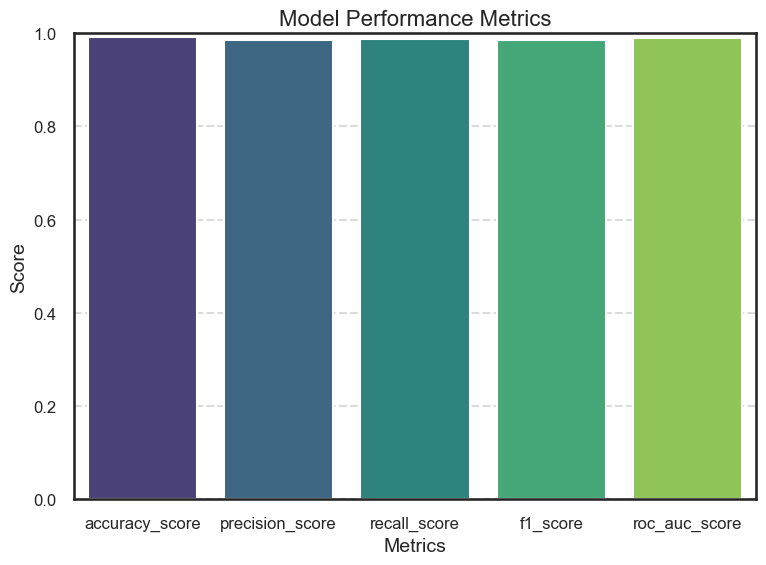

In [161]:
y_pred = final_rdf_model.predict(X_test)
rdf_per_test = model_performance_test(y_test, y_pred)
print(rdf_per_test)
plot_model_performance(rdf_per_test)

In [145]:
import pickle
pickle.dump(final_rdf_model,open('model.pkl','wb'))